<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Langchain/rag_question_answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):
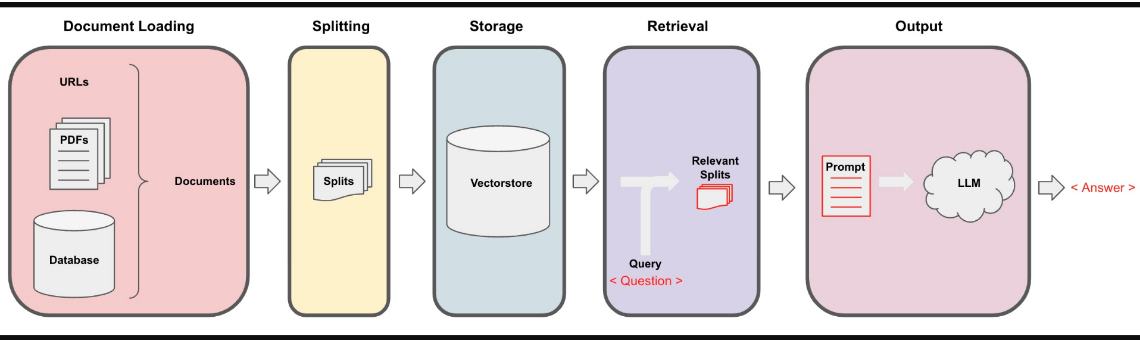

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB.

In [ ]:
import os
import sys

import openai

from dotenv import load_dotenv, find_dotenv
from google.colab import userdata
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate




In [ ]:
_ = load_dotenv(find_dotenv())

sys.path.append('../..')
openai.api_key  = userdata('gpt_api')
langsmith_key = userdata('langsmith')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
os.environ["LANGCHAIN_API_KEY"] = langsmith_key

persist_directory = 'docs/chroma/'
llm_name = "gpt-3.5-turbo"

embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
print(vectordb._collection.count())

209


In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [ ]:
llm = ChatOpenAI(model_name=llm_name, temperature=0)

### RetrievalQA chain

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result["result"]

'The major topics for this class include machine learning, statistics, and algebra. Additionally, there will be discussions on extensions of the material covered in the main lectures.'

### Prompt

In [ ]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [ ]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

'Yes, probability is a class topic as the instructor assumes familiarity with basic probability and statistics. Thanks for asking!'

In [ ]:
result["source_documents"][0]

Document(page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of as  a refresher course under prerequisite class. \nI'll say a bit more about that later as well.  \nLastly, I also assume familiarity with basi c linear algebra. And again, most undergraduate \nlinear algebra courses are more than enough. So if you've taken courses like Math 51, \n103, Math 113 or 

### RetrievalQA chain types

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [ ]:
result = qa_chain_mr({"query": question})
result["result"]

'Yes, probability is a class topic in the document.'

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce")

result = qa_chain_mr({"query": question})
result["result"]

'Yes, probability is a class topic in the document.'

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine")

result = qa_chain_mr({"query": question})
result["result"]

'The instructor, Andrew Ng, uses a probabilistic interpretation to derive the next learning algorithm, which will be the first classification algorithm discussed in the class. This algorithm will address classification problems where the value Y being predicted is discrete and can only take on a small number of values. Examples of classification problems include medical diagnosis and predicting whether a house will sell in the next six months. The course assumes familiarity with basic probability and statistics, as well as basic linear algebra, and will include review sections if needed. Additionally, the discussion sections will be used to review statistics and algebra as refreshers for those who need it. Later in the course, the discussion sections will also cover extensions for the material taught in the main lectures, as machine learning is a vast field with additional topics that may not have been covered in the main lectures.'

### RetrievalQA limitations

QA fails to preserve conversational history.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever())

In [ ]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

'Yes, probability is a class topic mentioned in the context provided. The instructor assumes familiarity with basic probability and statistics for the class.'

In [ ]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.